In [1]:
#\-- IMPORT MODULES, CLASSES AND METHODS --/#

import zipfile                          #############################
import os                               # || FILE SYSTEM / UTILS || #
import copy                             #############################
from prettytable import PrettyTable

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

import numpy as np                  ###################################
import pandas as pd                 # || EXPLORATIVE DATA ANALYSIS || #
import matplotlib.pyplot as plt     ###################################
import seaborn as sns
# https://towardsdatascience.com/handling-missing-data-like-a-pro-part-3-model-based-multiple-imputation-methods-bdfe85f93087 NumPyro, impyute,

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

import sklearn
import re
import importlib
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from sklearn import naive_bayes                         #########################
from sklearn import neural_network                      #  |-----------------|  #
from sklearn import svm                                 # || MODEL SELECTION || #
from sklearn import tree                                #  |-----------------|  #
from sklearn import linear_model                        #########################

# from PrunedCV import PrunedCV

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.model_selection import StratifiedKFold     ##########################
from sklearn.model_selection import ParameterGrid       # || MODEL VALIDATION || #
                                                        ##########################

%matplotlib inline


In [2]:
#\-- SET ENVIRONMENT --/#
# Before starting we need to store the data properly. We define an ad-hoc folder where we will store everything.
main_PATH = os.getcwd()

# We check whether we already have the data.                        
if 'data' not in os.listdir():                                      
                                                                    
    # Unzip files.
    with zipfile.ZipFile(r'summer_project_dataset.zip') as zip_ref:

        os.mkdir(main_PATH + '/data')   # We create the 'data' directory,
        os.chdir(main_PATH + '/data')   # we change directory,
    
        data_PATH = os.getcwd()         # we get the data path
        zip_ref.extractall(data_PATH)   # and we unzip there.       #####################
                                                                    # || FILE SYSTEM || #    
    file_PATH = data_PATH + '/summer_project_dataset'               #####################

else:

    # We just build the paths.
    data_PATH = main_PATH + '/data'
    file_PATH = data_PATH + '/summer_project_dataset'

# Finally, we go back to our main path.
os.chdir(main_PATH)

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# We also set a seed for reproducibility purposes.      #####################
SEED = 42                                               # || RANDOM SEED || #
np.random.seed(SEED)                                    #####################

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# LaTeX style plots.
plt.rcParams['figure.figsize'] = (12, 8)
# plt.rcParams['text.usetex']    = True         ############################
# plt.rcParams['font.family']    = 'serif'      # || DEFAULT PARAMETERS || #
# plt.rcParams['font.size']      = '10'         ############################

pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_rows', 10)

In [3]:
#\-- DATASET LOADING AND PREPROCESSING --/#
# Aome variables are stored as float, but they are actually int. Two reasons why:
#       -) nan values are considered as float --> first estimate them and then change the data type.
#       -) there are inconsistencies, especially in kw_max_min where some int values are float instead.
# for the moment just let's store everything as float, but further inspections are needed.

data_types = {
              'url' : str, 'timedelta' : int, 'shares' : int, 'data_channel' : str, 'weekday' : str, 
              
              'n_tokens_title'          : int, 'n_tokens_content'       : int, 'n_unique_tokens' : float, 'n_non_stop_words' : float,
              'n_non_stop_unique_tokens': float, 'average_token_length' : float,

              'num_hrefs' : int, 'num_self_hrefs' : int, 'num_imgs' : float, 'num_videos' : float,
              
              'kw_min_min' : float, 'kw_max_min' : float, 'kw_avg_min' : float, 'kw_min_max' : float, 'kw_max_max'   : float,
              'kw_avg_max' : float, 'kw_min_avg' : float, 'kw_max_avg' : float, 'kw_avg_avg' : float, 'num_keywords' : float,
              
              'self_reference_min_shares' : float, 'self_reference_max_shares' : float, 'self_reference_avg_sharess' : float,
              
              'LDA_00' : float, 'LDA_01' : float, 'LDA_02' : float, 'LDA_03' : float, 'LDA_04' : float,
              
              'global_subjectivity' : float, 'global_sentiment_polarity' : float, 'global_rate_positive_words' : float, 'global_rate_negative_words' : float,
              
              'rate_positive_words' : float, 'rate_negative_words' : float,
              
              'avg_positive_polarity' : float, 'min_positive_polarity' : float, 'max_positive_polarity' : float, 'avg_negative_polarity' : float,
              'min_negative_polarity' : float, 'max_negative_polarity' : float,

              'title_subjectivity' : float, 'title_sentiment_polarity' : float, 'abs_title_subjectivity' : float, 'abs_title_sentiment_polarity' : float,
              }                                                    
                                                                   
                                                                   
data = pd.read_csv(file_PATH + r'/development.csv',                 
                   usecols = lambda column: column != 'id', dtype = data_types)              
data


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
0,http://mashable.com/2014/09/08/safest-cabbies-...,121,12,1015,0.422018,1.0,0.545031,10,6,33.0,...,-0.160714,-0.500000,-0.071429,0.000000,0.000,0.500000,0.000,2900,bus,tuesday
1,http://mashable.com/2013/07/25/3d-printed-rifle/,532,9,503,0.569697,1.0,0.737542,9,0,NaN,...,-0.157500,-0.250000,-0.100000,0.000000,0.000,0.500000,0.000,1300,tech,thursday
2,http://mashable.com/2013/10/30/digital-dinosau...,435,9,232,0.646018,1.0,0.748428,12,3,4.0,...,-0.427500,-1.000000,-0.187500,0.000000,0.000,0.500000,0.000,17700,lifestyle,wednesday
3,http://mashable.com/2014/08/27/homer-simpson-i...,134,12,171,0.722892,1.0,0.867925,9,5,0.0,...,-0.216667,-0.250000,-0.166667,0.400000,-0.250,0.100000,0.250,1500,bus,wednesday
4,http://mashable.com/2013/01/10/creepy-robotic-...,728,11,286,0.652632,1.0,0.800000,5,2,NaN,...,-0.251786,-0.500000,-0.100000,0.200000,-0.100,0.300000,0.100,1400,tech,thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31710,http://mashable.com/2014/11/30/star-wars-guard...,37,11,440,0.564103,1.0,0.718978,10,2,NaN,...,-0.209167,-0.316667,-0.050000,0.000000,0.000,0.500000,0.000,1000,world,tuesday
31711,http://mashable.com/2014/11/14/uk-floods/,52,14,0,0.000000,0.0,0.000000,0,0,0.0,...,0.000000,0.000000,0.000000,0.666667,-0.700,0.166667,0.700,11000,lifestyle,monday
31712,http://mashable.com/2014/09/08/paypal-bitcoin-...,121,9,969,0.489583,1.0,0.710623,6,5,2.0,...,-0.400000,-1.000000,-0.050000,0.000000,0.000,0.500000,0.000,2400,tech,tuesday
31713,http://mashable.com/2013/08/23/mashable-androi...,503,11,1976,0.412308,1.0,0.621080,21,3,1.0,...,-0.323413,-1.000000,-0.050000,0.700000,-0.400,0.200000,0.400,6000,lifestyle,friday


<Axes: >

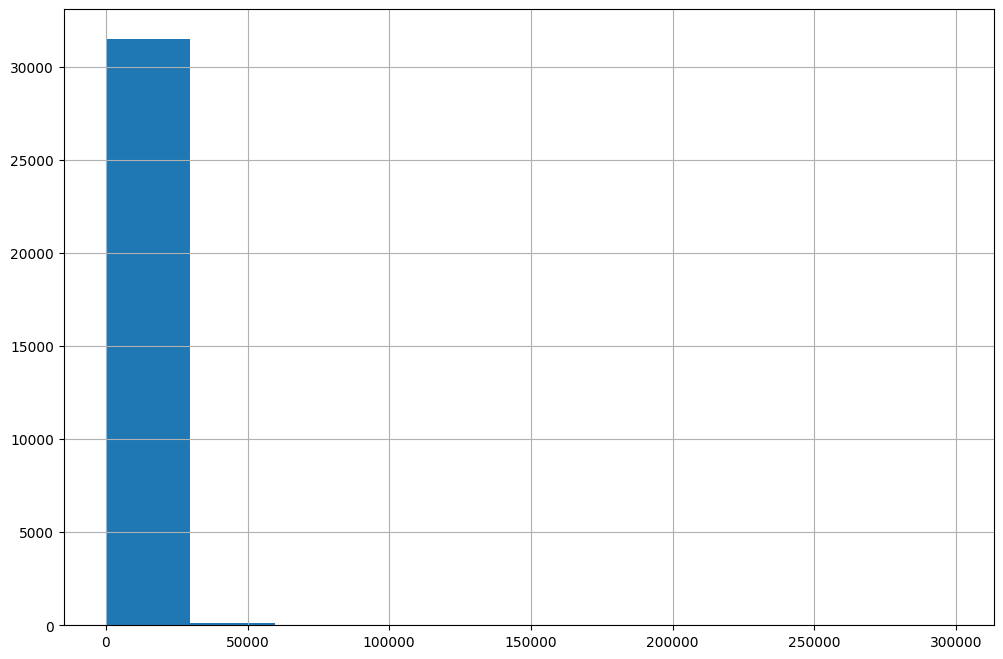

In [9]:
data['kw_max_avg'].hist()

<Axes: >

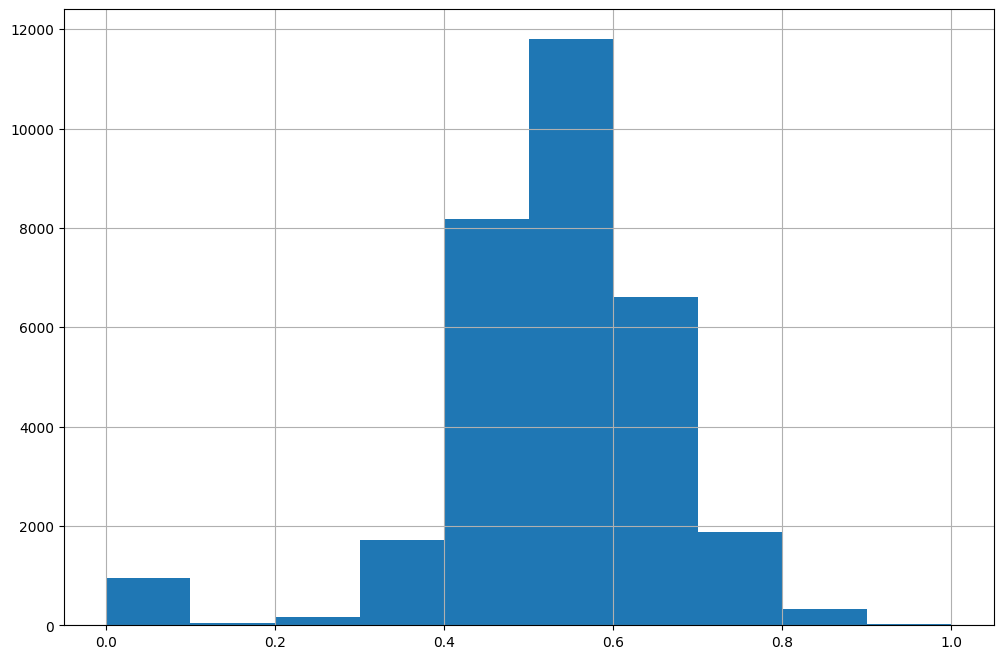

In [8]:
data['n_unique_tokens'].hist()

In [4]:

# kw_min_min: presence of several negative values.
# kw_max_min: presence of 1.59 and maybe other floats.
# kw_avg_min: presence of several negative values.
# kw_min_max: many zeros, check why
# kw_max_max: some values are zero, check why
# kw_avg_max: some values are zero, check why
# kw_min_avg: many zeros and some negative values
# kw_max_avg: some values are zero, check why
# kw_avg_avg: some values are zero, check why
# num_keywords: lot of nan


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31715 entries, 0 to 31714
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   url                           31715 non-null  object 
 1   timedelta                     31715 non-null  int64  
 2   n_tokens_title                31715 non-null  int64  
 3   n_tokens_content              31715 non-null  int64  
 4   n_unique_tokens               31715 non-null  float64
 5   n_non_stop_words              31715 non-null  float64
 6   n_non_stop_unique_tokens      31715 non-null  float64
 7   num_hrefs                     31715 non-null  int64  
 8   num_self_hrefs                31715 non-null  int64  
 9   num_imgs                      25340 non-null  float64
 10  num_videos                    25384 non-null  float64
 11  average_token_length          31715 non-null  float64
 12  num_keywords                  25397 non-null  float64
 13  k

In [5]:
for value in data['num_keywords']:
    print(value)

4.0
10.0
6.0
6.0
nan
nan
5.0
8.0
5.0
6.0
6.0
7.0
nan
8.0
5.0
10.0
8.0
7.0
6.0
nan
7.0
7.0
8.0
6.0
8.0
10.0
10.0
5.0
4.0
4.0
nan
8.0
7.0
6.0
6.0
6.0
10.0
8.0
8.0
3.0
8.0
5.0
6.0
7.0
10.0
10.0
10.0
7.0
10.0
7.0
7.0
6.0
6.0
4.0
nan
6.0
10.0
5.0
6.0
nan
5.0
8.0
10.0
6.0
10.0
6.0
5.0
9.0
6.0
10.0
4.0
6.0
10.0
7.0
6.0
7.0
7.0
5.0
8.0
7.0
nan
8.0
5.0
9.0
6.0
nan
10.0
nan
4.0
4.0
5.0
7.0
6.0
nan
5.0
7.0
5.0
7.0
7.0
4.0
9.0
5.0
9.0
10.0
9.0
7.0
8.0
8.0
7.0
10.0
7.0
5.0
8.0
nan
10.0
nan
nan
10.0
8.0
5.0
6.0
8.0
4.0
4.0
6.0
10.0
10.0
8.0
7.0
4.0
8.0
7.0
9.0
nan
6.0
nan
5.0
5.0
5.0
4.0
5.0
5.0
7.0
4.0
nan
10.0
8.0
9.0
5.0
10.0
3.0
6.0
8.0
9.0
6.0
7.0
10.0
nan
5.0
6.0
nan
nan
6.0
nan
8.0
7.0
8.0
7.0
9.0
10.0
4.0
4.0
9.0
6.0
6.0
10.0
nan
6.0
10.0
nan
7.0
4.0
nan
nan
7.0
nan
9.0
nan
9.0
6.0
9.0
6.0
6.0
7.0
5.0
8.0
nan
7.0
nan
6.0
8.0
10.0
nan
10.0
9.0
10.0
4.0
5.0
6.0
6.0
8.0
8.0
10.0
8.0
10.0
5.0
3.0
7.0
8.0
5.0
6.0
nan
10.0
6.0
10.0
10.0
8.0
10.0
10.0
4.0
7.0
6.0
9.0
3.0
10.0
8.0
7.0
4.0
7.0
3.0
8.

In [6]:
keywords = data.loc[: , 'num_keywords': 'kw_avg_avg']
keywords

,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg
0,4.0,-1.0,263.0,110.500000,6500.0,843300.0,398350.000000,1809.075000,3483.806797,2729.047648
1,10.0,4.0,3200.0,524.750000,0.0,843300.0,117960.000000,0.000000,4228.114286,2387.526307
2,6.0,4.0,939.0,198.666667,970.0,843300.0,573878.333333,954.500000,6192.239067,4385.022237
3,6.0,-1.0,2100.0,444.166667,5600.0,843300.0,311033.333333,2076.520000,4529.427500,3269.856640
4,NaN,217.0,552.0,356.200000,0.0,28000.0,6830.125000,0.000000,2240.536313,976.913444
...,...,...,...,...,...,...,...,...,...,...
31710,5.0,-1.0,718.0,222.800000,2900.0,843300.0,256540.000000,1596.571429,3413.509514,2245.759296
31711,10.0,-1.0,543.0,149.759000,39000.0,843300.0,423320.000000,3415.489909,15487.000000,5790.926061
31712,8.0,-1.0,656.0,196.666667,0.0,843300.0,210875.000000,0.000000,4381.853659,2292.406563
31713,10.0,4.0,621.0,174.400000,9100.0,843300.0,275820.000000,2767.959871,5009.901602,3543.244353


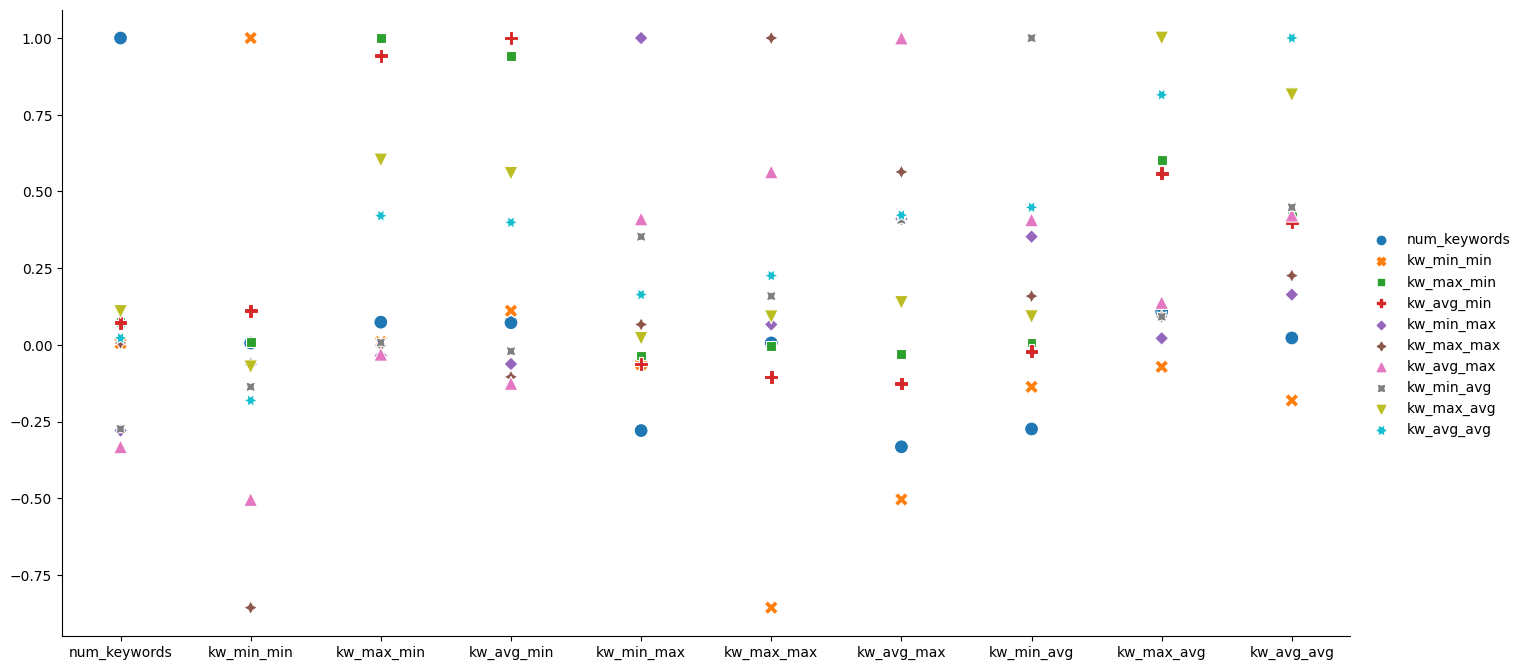

In [7]:
sns.relplot(keywords.corr(), height = 7, aspect = 2, s = 100)
# kw_max_min strongly positively correlated to kw_avg_min > 0.90
# kw_max_avg strongly positively correlated to kw_avg_avg > 0.80
# kw_min_min strongly negatively correlated to kw_max_max < 0.80

# kw_max_min quite positively correlated to kw_kw_max_avg > 0.60
# kw_avg_min quite positively correlated to kw_kw_max_avg > 0.60
# kw_max_max quite positively correlated to kw_kw_avg_max > 0.60


In [8]:
# kw_max_min: presence of 1.59 and maybe other floats.
# kw_max_min strongly related to kw_avg_min
keywords.corr()['kw_max_min'].sort_values(axis = 0) 

# We can predict kw_max_min starting from kw_avg_min

kw_min_max     -0.035063
kw_avg_max     -0.030842
kw_max_max     -0.003081
kw_min_avg      0.007410
kw_min_min      0.009662
num_keywords    0.073883
kw_avg_avg      0.420921
kw_max_avg      0.602539
kw_avg_min      0.942460
kw_max_min      1.000000
Name: kw_max_min, dtype: float64

<Axes: xlabel='kw_avg_min', ylabel='kw_max_min'>

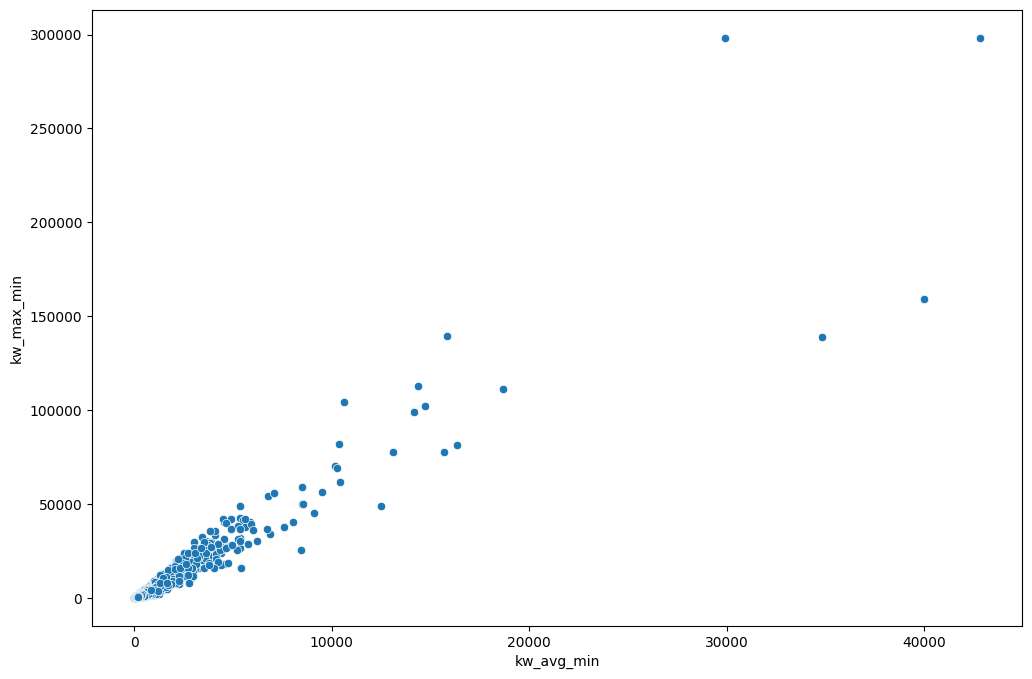

In [9]:

prediction = keywords[['kw_max_min', 'kw_avg_min']]
sns.scatterplot(x = prediction['kw_avg_min'], y = prediction['kw_max_min'])

In [10]:
# The mean is -0.23.
prediction[prediction['kw_max_min'] == 1.59]['kw_avg_min'].describe()

count    86.000000
mean     -0.232302
std       0.439711
min      -0.741000
25%      -0.482000
50%      -0.352500
75%      -0.136667
max       1.158333
Name: kw_avg_min, dtype: float64

array([[<Axes: title={'center': 'kw_max_min'}>,
        <Axes: title={'center': 'kw_avg_min'}>]], dtype=object)

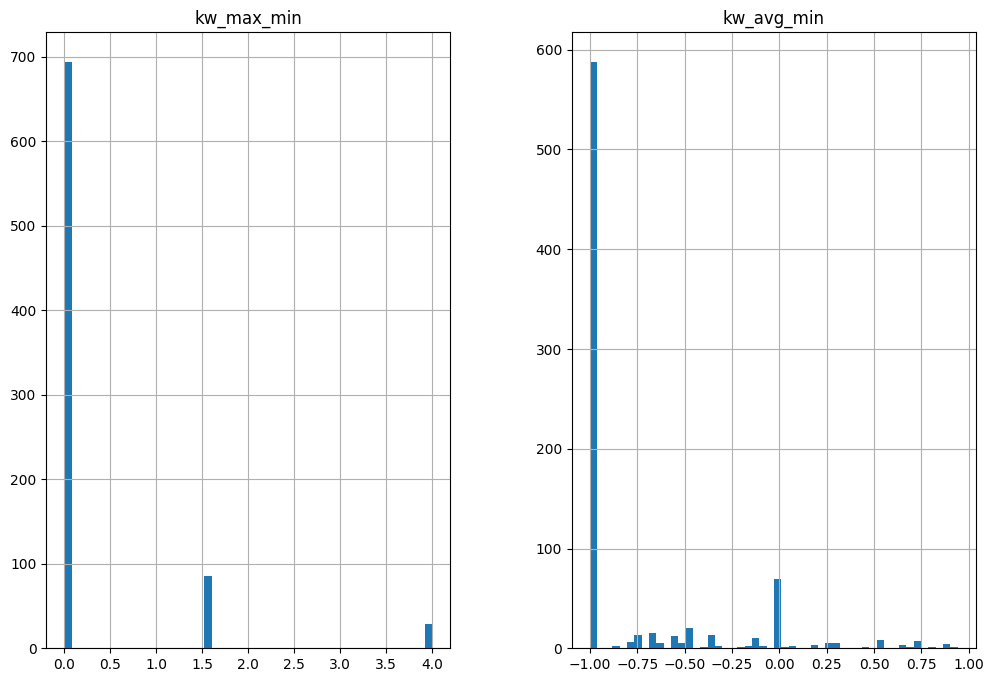

In [11]:

# There may be some problems since k_avg_min can't be negative.
prediction[prediction['kw_avg_min'] < 1].hist(bins = 50)


In [12]:
# There are missing values, really strange.
# for pred in prediction['kw_avg_min']:
#     print(pred)
pd.set_option('display.max_columns', None)
negative = data[data['kw_avg_min'] < 0]
negative

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
33,http://mashable.com/2014/07/30/cw-is-going-to-...,162,14,350,0.651429,1.0,0.834101,3,2,0.0,1.0,4.420000,6.0,-1.0,1.59,-0.3525,0.0,843300.0,485750.000000,0.000000,5373.831711,2781.062661,1300.0,1700.0,1500.0,0.866660,0.033336,0.033335,0.033335,0.033334,0.533492,0.201032,0.060000,0.017143,0.777778,0.222222,0.460714,0.100000,1.000000,-0.306481,-0.600000,-0.050000,0.550000,0.300000,0.050000,0.300000,4200,bus,wednesday
41,http://mashable.com/2014/09/01/school-supplies...,128,10,261,0.575290,1.0,0.722973,2,1,1.0,0.0,4.808429,5.0,-1.0,0.00,-1.0000,0.0,843300.0,249660.000000,0.000000,4174.373675,2304.467094,45100.0,45100.0,45100.0,0.040609,0.040004,0.040067,0.040063,0.839256,0.611667,-0.111667,0.015326,0.022989,0.400000,0.600000,0.327500,0.100000,0.800000,-0.525000,-1.000000,-0.125000,1.000000,-1.000000,0.500000,1.000000,1400,lifestyle,tuesday
54,http://mashable.com/2014/09/15/earthquake-rele...,115,10,1114,0.459165,1.0,0.680187,10,1,1.0,NaN,4.898564,NaN,-1.0,0.00,-1.0000,67700.0,843300.0,350800.000000,2183.873496,3484.224714,2685.549833,1400.0,1400.0,1400.0,0.066668,0.066667,0.733324,0.066667,0.066674,0.341095,0.075687,0.031418,0.018851,0.625000,0.375000,0.342079,0.033333,1.000000,-0.206444,-0.666667,-0.050000,0.000000,0.000000,0.500000,0.000000,1200,world,monday
101,http://mashable.com/2014/11/19/tim-ferriss/,48,9,319,0.572368,1.0,0.685864,8,0,1.0,0.0,4.686520,5.0,-1.0,0.00,-1.0000,25400.0,843300.0,282100.000000,2170.863140,3411.935940,2621.437577,0.0,0.0,0.0,0.040014,0.040000,0.839981,0.040000,0.040004,0.316667,-0.028571,0.015674,0.015674,0.500000,0.500000,0.310000,0.050000,0.500000,-0.340000,-0.500000,-0.200000,0.400000,-0.200000,0.100000,0.200000,846,world,friday
122,http://mashable.com/2014/09/07/jack-the-ripper...,122,11,315,0.593333,1.0,0.710526,5,2,NaN,0.0,4.492063,4.0,-1.0,0.00,-1.0000,0.0,843300.0,400650.000000,0.000000,3480.370953,2037.182017,781.0,781.0,781.0,0.299149,0.050004,0.550837,0.050003,0.050007,0.413542,0.178646,0.034921,0.006349,0.846154,0.153846,0.431818,0.200000,0.800000,-0.445833,-0.600000,-0.291667,0.000000,0.000000,0.500000,0.000000,1100,world,monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31394,http://mashable.com/2014/08/15/bill-gates-ice-...,146,15,310,0.621993,1.0,0.713568,10,1,1.0,0.0,4.635484,4.0,-1.0,0.00,-1.0000,0.0,843300.0,373650.000000,0.000000,3490.551453,2386.703935,2500.0,2500.0,2500.0,0.050004,0.799195,0.050138,0.050663,0.050000,0.436364,0.202370,0.041935,0.019355,0.684211,0.315789,0.525824,0.100000,1.000000,-0.260417,-0.400000,-0.187500,0.500000,-0.187500,0.000000,0.187500,2200,entertainment,friday
31431,http://mashable.com/2014/11/28/cliche-hashtags/,38,12,1233,0.499154,1.0,0.684282,13,5,2.0,26.0,4.471208,5.0,-1.0,0.00,-1.0000,210300.0,843300.0,636240.000000,2855.724779,5795.959521,4173.527528,1200.0,1900.0,1550.0,0.040002,0.041273,0.040086,0.838639,0.040000,0.443673,0.024767,0.056772,0.044607,0.560000,0.440000,0.398809,0.050000,1.000000,-0.433442,-1.000000,-0.050000,0.333333,0.166667,0.166667,0.166667,776,entertainment,monday
31471,http://mashable.com/

In [13]:
# nun_href is not consistent, there are a lot of wrong values. Same for n_img and n_videos.
data

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
0,http://mashable.com/2014/09/08/safest-cabbies-...,121,12,1015,0.422018,1.0,0.545031,10,6,33.0,1.0,4.656158,4.0,-1.0,263.0,110.500000,6500.0,843300.0,398350.000000,1809.075000,3483.806797,2729.047648,1100.0,22100.0,6475.000000,0.331582,0.050050,0.050035,0.050000,0.518333,0.471175,0.159889,0.041379,0.008867,0.823529,0.176471,0.333534,0.100000,0.8,-0.160714,-0.500000,-0.071429,0.000000,0.000,0.500000,0.000,2900,bus,tuesday
1,http://mashable.com/2013/07/25/3d-printed-rifle/,532,9,503,0.569697,1.0,0.737542,9,0,NaN,1.0,4.576541,10.0,4.0,3200.0,524.750000,0.0,843300.0,117960.000000,0.000000,4228.114286,2387.526307,0.0,0.0,0.000000,0.020007,0.020008,0.325602,0.020004,0.614379,0.477791,0.123520,0.033797,0.019881,0.629630,0.370370,0.419786,0.136364,1.0,-0.157500,-0.250000,-0.100000,0.000000,0.000,0.500000,0.000,1300,tech,thursday
2,http://mashable.com/2013/10/30/digital-dinosau...,435,9,232,0.646018,1.0,0.748428,12,3,4.0,1.0,4.935345,6.0,4.0,939.0,198.666667,970.0,843300.0,573878.333333,954.500000,6192.239067,4385.022237,1400.0,58800.0,30100.000000,0.033334,0.033697,0.033333,0.866302,0.033333,0.522234,-0.163235,0.017241,0.043103,0.285714,0.714286,0.468750,0.375000,0.5,-0.427500,-1.000000,-0.187500,0.000000,0.000,0.500000,0.000,17700,lifestyle,wednesday
3,http://mashable.com/2014/08/27/homer-simpson-i...,134,12,171,0.722892,1.0,0.867925,9,5,0.0,NaN,4.970760,6.0,-1.0,2100.0,444.166667,5600.0,843300.0,311033.333333,2076.520000,4529.427500,3269.856640,974.0,5600.0,2574.800000,0.700107,0.033335,0.033334,0.199402,0.033822,0.405128,-0.006410,0.011696,0.029240,0.285714,0.714286,0.500000,0.500000,0.5,-0.216667,-0.250000,-0.166667,0.400000,-0.250,0.100000,0.250,1500,bus,wednesday
4,http://mashable.com/2013/01/10/creepy-robotic-...,728,11,286,0.652632,1.0,0.800000,5,2,NaN,0.0,5.006993,NaN,217.0,552.0,356.200000,0.0,28000.0,6830.125000,0.000000,2240.536313,976.913444,822.0,822.0,822.000000,0.214708,0.025062,0.025016,0.025187,0.710028,0.418036,0.060089,0.034965,0.024476,0.588235,0.411765,0.303429,0.100000,0.6,-0.251786,-0.500000,-0.100000,0.200000,-0.100,0.300000,0.100,1400,tech,thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31710,http://mashable.com/2014/11/30/star-wars-guard...,37,11,440,0.564103,1.0,0.718978,10,2,NaN,NaN,4.784091,5.0,-1.0,718.0,222.800000,2900.0,843300.0,256540.000000,1596.571429,3413.509514,2245.759296,399.0,8900.0,4649.500000,0.040001,0.040000,0.839997,0.040000,0.040002,0.343382,-0.008088,0.013636,0.011364,0.545455,0.454545,0.105556,0.033333,0.2,-0.209167,-0.316667,-0.050000,0.000000,0.000,0.500000,0.000,1000,world,tuesday
31711,http://mashable.com/2014/11/14/uk-floods/,52,14,0,0.000000,0.0,0.000000,0,0,0.0,NaN,0.000000,10.0,-1.0,543.0,149.759000,39000.0,843300.0,423320.000000,3415.489909,15487.000000,5790.926061,0.0,0.0,0.000000,0.020000,0.135817,0.020000,0.804183,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.666667,-0.700,0.166667,0.700,11000,lifestyle,monday
31712,http://mashable.com/2014/09/08/paypal-bitcoin-...,121,9,

In [14]:
eval = pd.read_csv('data/data/evaluation.csv')
# Something strange in the URL. The past pages are really different from the actual one. Just check this on Wayback Machine.
# It is just an information related to the past.
# num_keyword does not count the single topic, but just the number of words! Work on unigram, bigram ecc
# maybe kw ... refers to the number of shares regarding that topic. Yhey are an average, a max and a mix
# the content is 0 only in certain cases...it may be useful to count the number of tokens in the past and substitute the value.
# num_keyword can be found in the html, it has been scraped using stemming and only one instance of each stem is stored.
# for some articles we have 0 tokens and they can be found with Wayback Machine, viceversa with other articles
# IMPORTANT: consider deltatime when using wayback machine, it is necessary to retrieve the right information in the time.
# Notice that href are part of the content. If tokens_content == 0 then also href will be.
# It seems that kw_min kw_max are all the same for same topic